In [73]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np 
import pandas as pd 
import torch.nn.functional as F
import torch.nn as nn
import os
from os import listdir
import tensorflow as tf
import torch
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import imutils  
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
import tensorflow as tf
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
import pickle
from keras.models import Sequential
import numpy as np 
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from PIL import Image
from keras.datasets import mnist
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter


#python files
from pyscript.UTILS.class_dict import dictionary
from pyscript.loadImDat import scaleTo01,loadData

In [93]:
Yes_IMAGES = glob.glob('/nvme_ssd/bensCode/kaggleMRI/brain_tumor_dataset/yes/*.jpg')
No_IMAGES = glob.glob('/nvme_ssd/bensCode/kaggleMRI/brain_tumor_dataset/no/*.jpg')
def load_image(path):
    image_list = np.zeros((len(path), 160, 160, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(160, 160))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list
x_train = load_image(Yes_IMAGES)
y_train = load_image(Yes_IMAGES)
x_test = load_image(No_IMAGES)
def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]
x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)
print(x_train.shape)
print(y_train.shape)
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))
#add a model save method

(68, 160, 160, 1)
(68, 160, 160, 1)
68
68
18
18


In [101]:
class Autoencoder():
    def __init__(self):
        self.img_rows = 160
        self.img_cols = 160
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(lr=0.001)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        h = Conv2D(128, (3, 3), activation='relu', padding='same')(h)
        h = Conv2D(256, (3, 3), activation='relu', padding='same')(h)
        h = MaxPooling2D((2, 2), padding='same')(h)
        
        # decoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = Conv2D(128, (3, 3), activation='relu', padding='same')(h)
        h = Conv2D(256, (3, 3), activation='relu', padding='same')(h)
        h = Conv2D(512, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)
        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20,poisson=False,laplace=False,fista=False):
        if laplace:
            x_train=self.add_laplace_noise(x_train)
            x_val=self.add_laplace_noise(x_val)
        elif poisson:
            x_train=self.add_poisson_noise(x_train)
            x_val=self.add_poisson_noise(x_val)
        elif fista:
            x_train=self.fista_encode_images(x_train)
            x_val=self.fista_encode_images(x_val)
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=7,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    def encode_images(self,images,poisson=False,laplace=False):
        if poisson:
            images=self.add_poisson_noise(images)
        if laplace:
            images=self.add_laplace_noise(images)
        encoded_images=self.fista_encode_images(images)
        return encoded_images
    def add_poisson_noise(self,images):
        noisy_images=[]
        for img in images:
            img[img<0]=0
            img_mask=np.random.poisson(img/255.0 * .05)/.05*255
            img=img+img_mask
            noisy_images.append(img)
        return np.array(noisy_images)
    def add_laplace_noise(self,images):
        noisy_images=[]
        for img in images:
            img[img<0]=0
            img_mask=np.random.laplace(img,scale=.05)
            img=img+img_mask
            noisy_images.append(img)
        return np.array(noisy_images)
    def get_fista_encoder(self):
        model_dir="/nvme_ssd/bensCode/SparseCoding/models/mriModelKaggle.pt"
        fista_model=torch.load(model_dir)
        return fista_model
    def fista_encode_images(self,images):
        #assumption is images is an array of numpy images
        # model=self.get_fista_encoder()
        fista_model=self.get_fista_encoder()
        encoded_images=[]
        for img in images:
            img=torch.tensor(img).to("cuda:0")
            img=img.float()
            # print(img.shape)
            img=img.reshape(1,-1)
            img_encoded=fista_model(img)
            img_encoded=img_encoded.reshape(self.img_rows,self.img_cols)
            img_encoded=img_encoded.detach().cpu().numpy()
            encoded_images.append(img_encoded)
        return np.array(encoded_images)
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

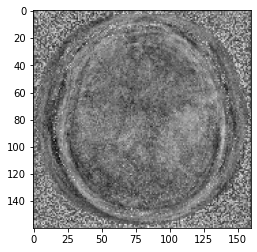

In [98]:
class classifier():
    def __init__(self):
        self.width=160
        self.height=160
        pass
    def get_fista_encoder(self):
        model_dir="/nvme_ssd/bensCode/SparseCoding/models/mriModelKaggle.pt"
        fista_model=torch.load(model_dir)
        return fista_model
    def fista_encode_images(self,images):
        #assumption is images is an array of numpy images
        # model=self.get_fista_encoder()
        fista_model=self.get_fista_encoder()
        encoded_images=[]
        for img in images:
            img=torch.tensor(img).to("cuda:0")
            img=img.float()
            # print(img.shape)
            img=img.reshape(1,-1)
            img_encoded=fista_model(img)
            img_encoded=img_encoded.reshape(self.width,self.height)
            img_encoded=img_encoded.detach().cpu().numpy()
            encoded_images.append(img_encoded)
        return np.array(encoded_images)
    def train_test(self,laplace=False,saltPepper=False,fista=False):
        files=glob.glob("/nvme_ssd/bensCode/kaggleMRI/brain_tumor_dataset/**/*.jpg")
        # print(files)
        labels=[]
        for file in files:
            if "no" in file:
                labels.append(0)
            else:
                labels.append(1)
        self.images=[]
        for file in files:
            img=Image.open(file)
            image=img.resize((self.width,self.height),Image.ANTIALIAS)
            array_img=np.array(image)
            arr_img=array_img[:,:,0] if len(array_img.shape)==3 else array_img
            self.images.append(arr_img)
        images,labels=shuffle(self.images,labels)
        arrimg=np.array(images)
        # print(arrimg)
        length=len(labels)
        size=round(length*.8)
        xtrain=arrimg[:size,:self.width,:self.height,np.newaxis]
        xtest=arrimg[:size,:self.width,:self.height,np.newaxis]
        ytrain=labels[:size]
        ytest=labels[:size]
        if fista:
            xtrain=self.fista_encode_images(xtrain)
            xtrain=xtrain.reshape(-1,160,160,1)
            xtest=self.fista_encode_images(xtest)
            xtest=xtest.reshape(-1,160,160,1)
        return xtrain,xtest,ytrain,ytest
    
    def classifierModel(self):
        model = Sequential()
        model.add(Conv2D(50, kernel_size=(3,3), padding='same', activation='relu', input_shape=(160, 160,1)))
        model.add(Conv2D(75, kernel_size=(3,3), padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        model.add(Conv2D(125, kernel_size=(3,3), padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(250, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
        return model
    def trainModel(self,epochs,xtrain,xtest,ytrain,ytest):
        model=self.classifierModel()
        history=model.fit(xtrain,np.array(ytrain),epochs=epochs,validation_data=(xtest,np.array(ytest)))
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()


Epoch 1/100
5/5 [==============================] - 8s 2s/step - loss: 396.5063 - accuracy: 0.5656 - val_loss: 25.8657 - val_accuracy: 0.5036
Epoch 2/100
5/5 [==============================] - 8s 2s/step - loss: 45.7307 - accuracy: 0.4521 - val_loss: 0.6858 - val_accuracy: 0.5693
Epoch 3/100
5/5 [==============================] - 8s 2s/step - loss: 0.8543 - accuracy: 0.4870 - val_loss: 0.6935 - val_accuracy: 0.4964
Epoch 4/100
5/5 [==============================] - 8s 2s/step - loss: 0.6813 - accuracy: 0.5536 - val_loss: 0.6936 - val_accuracy: 0.4964
Epoch 5/100
5/5 [==============================] - 8s 2s/step - loss: 0.6904 - accuracy: 0.5714 - val_loss: 0.6929 - val_accuracy: 0.4964
Epoch 6/100
5/5 [==============================] - 8s 2s/step - loss: 0.6963 - accuracy: 0.4866 - val_loss: 0.6937 - val_accuracy: 0.4964
Epoch 7/100
5/5 [==============================] - 8s 2s/step - loss: 0.6935 - accuracy: 0.5149 - val_loss: 0.6938 - val_accuracy: 0.4964
Epoch 8/100
5/5 [=============

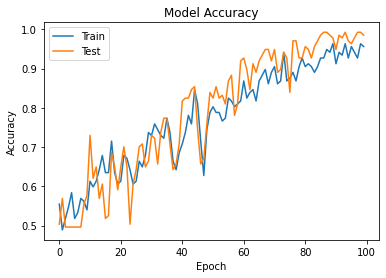

In [57]:
#this is the classification model
i=classifier()
xtrain,xtest,ytrain,ytest=i.train_test(fista=True)
plt.imshow(xtrain[0],cmap='gray')
plt.show()
i.trainModel(100,xtrain,xtest,ytrain,ytest)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 160, 160, 1)]     0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 160, 160, 64)      640       
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 160, 160, 128)     73856     
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 160, 160, 256)     295168    
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 80, 80, 256)       0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 80, 80, 64)        147520    
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 80, 80, 128)       7385

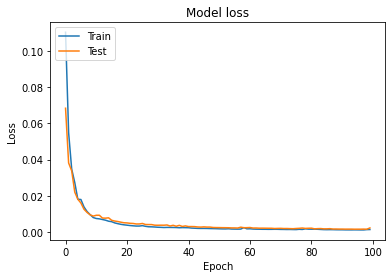

In [102]:
#this is the recreation model
ae = Autoencoder()
ae.train_model(x_train, y_train, x_val, y_val, epochs=100, batch_size=20,laplace=True)

85


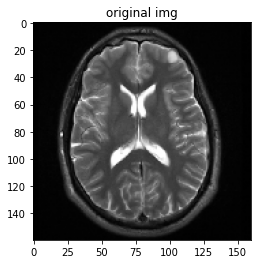

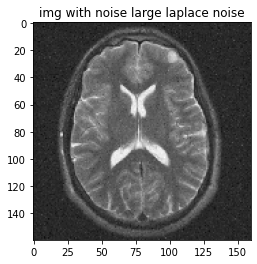

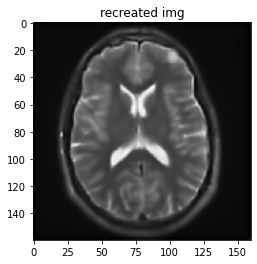

In [103]:
preds = ae.eval_model(x_test)
print(len(preds))
preds_0 = preds[60] * 255.0
preds_0 = preds_0.reshape(160, 160)
x_test_0 = x_test[60] * 255.0
encoded=ae.add_laplace_noise(x_test)
encoded1=encoded[60]
x_test_0 = x_test_0.reshape(160, 160)
plt.imshow(x_test_0, cmap='gray')
plt.title("original img")
plt.show()
plt.imshow(encoded1,cmap='gray')
plt.title('img with noise large laplace noise')
plt.show()
plt.imshow(preds_0, cmap='gray')
plt.title("recreated img")
plt.show()

Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 160, 160, 1)]     0         
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 160, 160, 64)      640       
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 160, 160, 128)     73856     
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 160, 160, 64)      73792     
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 160, 160, 1)       577       
Total params: 148,865
Trainable params: 148,865
Non-trainable params: 0
_________________________________________________________________
<class 'numpy.ndarray'>
(68, 160, 160, 1)
(68, 160, 160, 1)
<class 'numpy.ndarray'>
Epoch 1/50
4/4 [==================

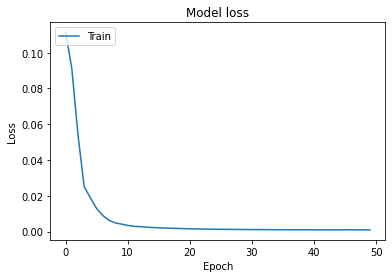

In [127]:
ae = Autoencoder()
# print(x_train.shape)
# xtrain=np.array(ae.encode_images(x_train))
xtrain=ae.add_laplace_noise(x_train)
# xtrain=x_train
ytrain=y_train
# x_val=ae.encode_images(x_val,laplace=True)
# y_val=ae.encode_images(y_val)
print(type(xtrain))
print(xtrain.shape)
print(ytrain.shape)
print(type(y_train))
# plt.imshow(xtrain[1])
# plt.show()
# plt.imshow(xtrain[10])
# plt.show()
# plt.imshow(xtrain[15])
# plt.show()
ae.train_model(xtrain, ytrain, x_val, y_val, epochs=50, batch_size=20)


85


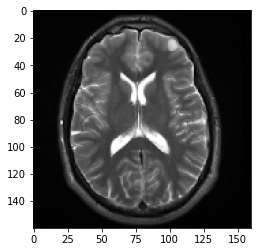

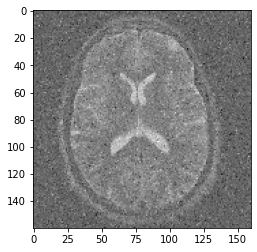

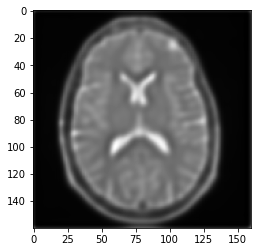

In [77]:
preds = ae.eval_model(x_test)
print(len(preds))
preds_0 = preds[60] * 255.0
preds_0 = preds_0.reshape(160, 160)
x_test_0 = x_test[60] * 255.0
encoded=ae.add_laplace_noise(x_test)
encoded1=encoded[60]
x_test_0 = x_test_0.reshape(160, 160)
plt.imshow(x_test_0, cmap='gray')
plt.show()
plt.imshow(encoded1,cmap='gray')
plt.show()
plt.imshow(preds_0, cmap='gray')
plt.show()

68


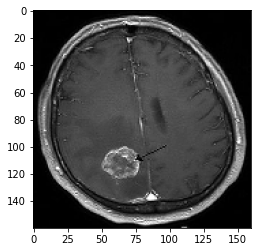

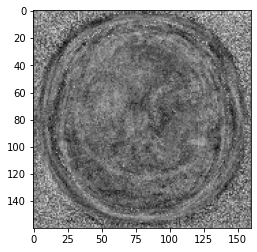

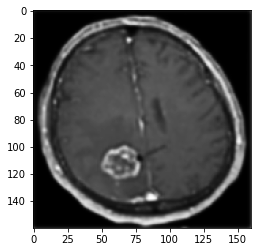

In [26]:
preds = ae.eval_model(x_test)
print(len(preds))
preds_0 = preds[30] * 255.0
preds_0 = preds_0.reshape(160, 160)
x_test_0 = x_train[30] * 255.0
encoded=ae.encode_images(x_test)
encoded1=encoded[30]
x_test_0 = x_test_0.reshape(160, 160)
plt.imshow(x_test_0, cmap='gray')
plt.show()
plt.imshow(encoded1,cmap='gray')
plt.show()
plt.imshow(preds_0, cmap='gray')
plt.show()

In [ ]:
#guassian noise, 5% is enough HOWEVER
#noise is relative to the size of the image

#NEXT STEP TODO:
#Add Laplace noise and Poisson noise and Impulse noise
#TODO: add tensorboard